cd ..

In [6]:
ls

2010 Census Tracts/
ACS5yearBK/
CCRB Data Layout Table.xlsx
NYC Street Centerline (CSCL)/
NYC_Police_Precincts_2020/
NYPD-repository/
NYPD_Arrest_Historic_DataDictionary.xlsx
NYPD_Arrests_Data__Historic_.csv
NYPD_Criminal_Court_Summons__Historic_.csv
allegations_20200726939.csv
nyc_2010censusblocks_2020policeprecincts (1).csv


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import geopandas as gpd
from scipy.stats import gaussian_kde
import seaborn as sns
from shapely.geometry import shape, Point
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.dates as mdates
import plotly.express as px
import plotly.graph_objects as go

Sources
- NYC Centerline Data 
-- https://data.cityofnewyork.us/City-Government/NYC-Street-Centerline-CSCL-/exjm-f27b
- NYTimes Mapping Segregation
-- https://www.nytimes.com/interactive/2015/07/08/us/census-race-map.html?mtrref=www.google.com&assetType=PAYWALL
- US Census Population Data
-- https://www.census.gov/quickfacts/fact/table/kingscountybrooklynboroughnewyork,newyorkcitynewyork/PST045219
- Racial Dot Map
-- http://racialdotmap.demographics.coopercenter.org/
- NYPD Precincts Map
-- https://data.cityofnewyork.us/Public-Safety/Police-Precincts/78dh-3ptz
- NYPD Arrests Data
-- https://data.cityofnewyork.us/Public-Safety/NYPD-Arrests-Data-Historic-/8h9b-rp9u
- NYC Census Tracts Data
-- https://data.cityofnewyork.us/City-Government/2010-Census-Tracts/fxpq-c8ku
- ACS Tables
-- https://data.census.gov/cedsci/
- NHGIS
-- https://data2.nhgis.org/main
- Precinct Data
-- https://johnkeefe.net/nyc-police-precinct-and-census-data
- Marijuana Consumption
-- https://www1.nyc.gov/site/doh/about/press/pr2019/health-department-releases-first-comprehensive-report-on-cannabis.page

Important Resources
- https://python-graph-gallery.com/134-how-to-avoid-overplotting-with-python/
- https://python-graph-gallery.com/86-avoid-overlapping-in-scatterplot-with-2d-density/
- https://datashader.org/getting_started/Introduction.html
- https://seaborn.pydata.org/generated/seaborn.kdeplot.html
- http://andrewgaidus.com/Dot_Density_County_Maps/
- https://towardsdatascience.com/walkthrough-mapping-basics-with-bokeh-and-geopandas-in-python-43f40aa5b7e9
- https://www.bloomberg.com/news/articles/2013-05-30/the-most-important-population-statistic-that-hardly-ever-gets-talked-about
- https://www.census.gov/data/tables/2015/demo/metro-micro/commuting-flows-2015.html
- https://wagner.nyu.edu/files/rudincenter/dynamic_pop_manhattan.pdf

### LOAD ALL DATA

In [8]:
#census tract map of Brooklyn
census_tracts = gpd.read_file(
    '2010 Census Tracts/geo_export_7c8515b7-143e-4d01-972b-35868adf5281.shp')
bk_census_tracts = census_tracts[census_tracts['boro_name'] == 'Brooklyn']

In [9]:
#ACS census tract demo data
acs_demo = pd.read_csv('ACS5yearBK/ACS5yearBK_data.csv', skiprows=0).drop(['Unnamed: 0'], axis=1)
#ACS census tract demo data dictionary
acs_data_dict = pd.read_csv('ACS5yearBK/ACS5yearBK_data_dict.csv',skiprows=1)

In [10]:
#street centerline map of nyc
our_streets = gpd.read_file('NYC Street Centerline (CSCL)/geo_export_c00f9a7a-d11b-4436-bc33-9fcb9a060d9d.shp')

In [11]:
#Borough Codes
# 1-Man 2-Bronx 3-Brooklyn 4-Queens 5-Staten Island
#brooklyn streets
bk_base = (our_streets[(our_streets['borocode'] == '3') & #brooklyn=3 
                       (our_streets['rw_type'] != 14)]) #remove ferry routes

In [12]:
#create a baselayer for non-bk centerline map
notbk_base = (our_streets[(our_streets['borocode'] != '3') & #brooklyn=3 
                       (our_streets['rw_type'] != 14)]) #remove ferry routes

In [13]:
#read column dictionary
xls = pd.ExcelFile('NYPD_Arrest_Historic_DataDictionary.xlsx')
arrest_col_info = pd.read_excel(xls, 'Column Info', header=1)
#delete filler columns with NaN vals
col_info = arrest_col_info.drop(columns=list(arrest_col_info.columns[2:]))

In [14]:
#read arrests file
df = pd.read_csv('NYPD_Arrests_Data__Historic_.csv')

In [15]:
#precinct shapefile
precinct_shp = gpd.read_file('NYC_Police_Precincts_2020/geo_export_87553334-fdcd-4d0c-8ab2-43a5e2975733.shp')

In [16]:
#precinct census data
precinct_census = pd.read_csv('nyc_2010censusblocks_2020policeprecincts (1).csv').drop('Unnamed: 0',axis=1)\
.dropna(subset=['precinct_2020'])

### CLEAN ARRESTS DATA

In [17]:
def clean_arrests_data(df):
    #limit arrest file to Brooklyn
    df = df[ (df['Latitude'] < 40.8) & (df['ARREST_BORO'] == 'K') ]
    #change arrest dates to datetime
    df['ARREST_DATE'] = pd.to_datetime(df['ARREST_DATE'])
    #limit jurisdiction codes to 0->3
    df['JURISDICTION_CODE'] = df['JURISDICTION_CODE'].apply(lambda x: 3 if x>2 else x)
    
    #Limit age groups to 6 main categories
    #First, create the list of the 6 main category labels
    age_groups = df['AGE_GROUP'].value_counts().sort_values(ascending=False)[:5].index.to_list()
    #Write eveything that is not in one of these categories as NaN
    df['AGE_GROUP'] = df['AGE_GROUP'].apply(lambda x: np.nan if x not in age_groups else x)
    #turn all of those NaN age_group values into real age groups based on the proportion of age groups in the data
    #1. make a dictionary of the age groups and their percentages in the data
    age_group_dict = dict(df['AGE_GROUP'].value_counts(normalize=True))
    age_group_keys = list(age_group_dict.keys())
    age_group_values = list(age_group_dict.values())
    #2. randomly fillna with the proportion of each value
    df['AGE_GROUP'] = df['AGE_GROUP'].fillna(
        pd.Series(np.random.choice(age_group_keys, p=age_group_values, size=len(df))))
    
    #Group "black hispanic" and "white hispanic" into "hispanic"
    #This could be flawed
    #*** Before combining, "White Hispanic" was 26% and "Black Hispanic" was 8% ***
    df['PERP_RACE'] = df['PERP_RACE'].apply(lambda x: 'HISPANIC' if x.endswith('HISPANIC') else x)

    #create columbs for year, month, day
    df['ARREST_YEAR'] = df['ARREST_DATE'].apply(lambda x: x.year)
    df['ARREST_MONTH'] = df['ARREST_DATE'].apply(lambda x: x.month)
    df['ARREST_DAY'] = df['ARREST_DATE'].apply(lambda x: x.day)

    #combine lat/lon into one column
    df['lonlat'] = list(zip(df['Longitude'], df['Latitude']))
    #convert lat/lon into "points"
    df['point'] = df['lonlat'].apply(lambda x: Point(x))

    #create day of year column that find the day number of the year
    df['dayofyear'] = df['ARREST_DATE'].apply(lambda x: x.timetuple().tm_yday)
    
    #turn into geodataframe
    df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Longitude'],df['Latitude']))
    
    return df

df = clean_arrests_data(df)

/Users/maxcohen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/maxcohen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/maxcohen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

### CLEAN ACS DATA
##### Merge acs data with census tracts shape file

In [18]:
def clean_acs_data(acs_demo):
    #remove margin of error columns
    acs_demo = acs_demo[acs_demo.columns.drop(list(acs_demo.filter(regex='Margin of Error')))]
    
    #create ctlabel column with just the "number" name of census tract
    #now this will match the bk_census_tract column
    acs_demo['ctlabel'] = acs_demo['Geographic Area Name']\
    .apply(lambda x: x.split('Census Tract ')[1].split(', Kings County')[0])
    
    #merge the acs_demo data onto the bk_census_tracts (shortened to just geometry and census tract name)
    acs_demo = bk_census_tracts[['ctlabel','geometry']].merge(acs_demo, on='ctlabel')
    
    #turn into a geodataframe
    acs_demo = gpd.GeoDataFrame(acs_demo, geometry=acs_demo['geometry'])
    
    return acs_demo

acs_demo = clean_acs_data(acs_demo)

### CLEAN PRECINCTS CENSUS DATA
##### Merge precinct census data with precinct shapefile

In [19]:
def clean_precinct_census(precinct_census):
    #brooklyn county number = 47
    bk_precinct_census = precinct_census[precinct_census['COUNTY'] == 47]
    
    #group and sum by precinct
    bk_precinct_census = bk_precinct_census.groupby(['precinct_2020']).sum()\
    .drop(columns=['geoid10','SUMLEV','STATE','COUNTY','TRACT','BLOCK','INTPTLAT','INTPTLON'])\
    .reset_index()
    
    #change precinct column to 'integer'
    bk_precinct_census['precinct_2020'] = bk_precinct_census['precinct_2020'].astype('int64')
    #change name of precinct column to match shapefile 
    bk_precinct_census.rename(columns={'precinct_2020':'precinct'},inplace=True)    
    
    #MERGE WITH PRECINCT SHAPE FILE
    #change shapefile precinct column to integer
    precinct_shp['precinct'] = precinct_shp['precinct'].astype('int64')
    #merge
    bk_precinct_census = bk_precinct_census.merge(precinct_shp[['precinct','geometry']], on='precinct')
    
    #turn into a geodataframe
    bk_precinct_census = gpd.GeoDataFrame(bk_precinct_census, geometry=bk_precinct_census['geometry'])
    
    return bk_precinct_census

bk_precinct_census = clean_precinct_census(precinct_census)

Relational Databases

1. arrest data
    - geometry (point)
    - precinct  
2. acs data
    - geometry (polygon)
    - census tract
3. census data by precinct
    - geometry (polygon
    - precinct

### MAPPING BASELAYERS

In [20]:
#a function to remove axes spines, ticks, and labels
def set_map_axes(ax=None):
    [s.set_visible(False) for s in ax.spines.values()]
    [t.set_visible(False) for t in ax.get_xticklines()]
    [t.set_visible(False) for t in ax.get_yticklines()]
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    #brooklyn lat/lon limits for maps
    ax.set_xlim(-74.050,-73.850)
    ax.set_ylim(40.565,40.745)
    
    return ax

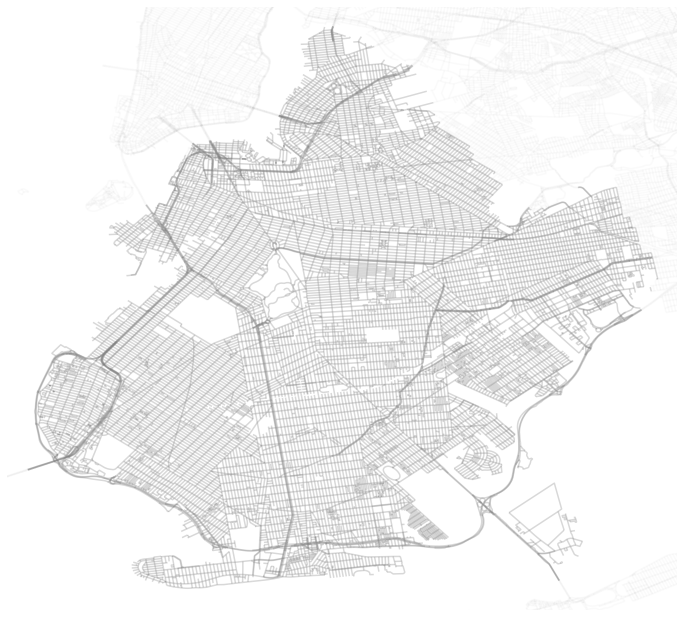

In [23]:
#brooklyn streets baselayer
fig,ax = plt.subplots(figsize=(12,12))

#bk centerline map
bk_base.plot(ax=ax, color='grey', alpha=.3, zorder=2)
#not bk centerline map
notbk_base.plot(ax=ax, color='lightgrey', alpha=.1, zorder=1)

set_map_axes(ax=ax)

plt.show()